In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils import data
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import time
import sys
import random
from google.colab.patches import cv2_imshow

In [0]:
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cuda:0


In [0]:
class InitialBlock(nn.Module):
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)
        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        side = self.maxpool(x)
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

In [0]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag

        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        # x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            extras = extras.to(device)
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [0]:
class UBNeck(nn.Module):
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        # x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # Concat
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        # x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class SAD(nn.Module):
  def __init__(self):
    super().__init__()


    # self.l2_norm = torch.norm(activation, dim = 1)
    self.bilinear_upsample = nn.Upsample(size = (256,512), mode='bilinear')
    self.spatial_softmax = torch.nn.Softmax()
    # self.sum = torch.sum(dim = 0)


  def forward(self, x):
    
    
    # attention_map = self.bilinear_upsample(x)
    x = torch.sum(torch.abs(x), dim = 1)
    x = x.unsqueeze(1)
    x = self.bilinear_upsample(x)
    x = x.squeeze(1)
    a = x.size()[1]
    b = x.size()[2]
    x = x.reshape(x.size()[0], -1, 1)
    # print('reshape1',x.size())
    x = self.spatial_softmax(x)
    x = x.reshape(x.size()[0], 1, a, b)
    # print('reshape2',x.size())
    return x

In [0]:
class ENet(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        self.at_gen1 = SAD()
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.at_gen2 = SAD()
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)

        self.at_gen3 = SAD()
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.at_gen4 = SAD()
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x, with_SAD = True):
        
        # The initial block
        x = self.init(x)
        if(with_SAD):
          #first attention map
          A1 = self.at_gen1(x)

        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        if(with_SAD):
          #Second attention map
          A2 = self.at_gen2(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        if(with_SAD):
          #third attention map
          A3 = self.at_gen3(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        if(with_SAD):
          #forth attention map
          A4 = self.at_gen4(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        if(not with_SAD):
          return x

        else:
          return x, A1, A2, A3, A4

In [0]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256,512)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_train_label = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

transform_test = transforms.Compose([
    # transforms.Resize((128,128)),  
    # transforms.Resize((375,1242)),                                   
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [0]:
class Dataset(data.Dataset):
#   'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels, setname):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.setname = setname

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        # X = torch.load('data/' + ID + '.pt')
        X = Image.open(ID)
        X = X.crop((0,0,0,20))
        X = transform_train(X)
        
        y = Image.open(self.labels[ID])
        y = y.crop((0,0,0,20))
        y = transform_train_label(y)

        return X, y


class MyDataset(data.Dataset):
    def __init__(self, list_IDs, labels, train=True):
        
        self.labels = labels
        self.list_IDs = list_IDs
        self.train = train

    def transform(self, image, mask):
    
        # Resize
        resize = transforms.Resize(size=(256, 512))
        image = resize(image)
        mask = resize(mask)
        # depth = resize(depth)

        # Random horizontal flipping
        if random.random() > 0.5 and train:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)

        # Transform to tensor
        t = transforms.ToTensor()
        image = t(image)
        mask = t(mask)
        # depth = t(depth)

        # Normalise
        normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        normalize1 = transforms.Normalize([0.491], [0.2023])
        image = normalize(image)
        # depth = normalize1(depth)

        # image = torch.cat((image, depth), 0)
    
        return image, mask

    def __getitem__(self, index):
        ID = self.list_IDs[index]
        # new_path = '/content/drive/My Drive/depth_city/'
        image = Image.open(ID)
        mask = Image.open(self.labels[ID])
        # depth = Image.open(new_path + ID[33:])
        # ColorJitter
        color = transforms.ColorJitter(brightness=.05, contrast=.05, hue=.05, saturation=.05)
        if train:
            image = color(image)
        w, h = image.size
        image = image.crop((0, 0, w, h-20))
        mask = mask.crop((0, 0, w, h-20))
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.list_IDs)

In [0]:
path = '/content/drive/My Drive/New_City/'
files_img = ['cityscapes/', 'gtFine/']

In [0]:
partition = {}
labels = {}

for f in os.listdir(path + files_img[0]):
    partition[f] = []
    
    for city in os.listdir(path + files_img[0] + f):
        for image_name in os.listdir(path + files_img[0] + f + '/' + city):
            key = path + files_img[0] + f + '/' + city + '/' + image_name
            value = path + files_img[1] + f + '/' + city + '/' + image_name[:-16] + '_gtFine_color.png'
            if image_name != '.ipynb_checkpoints':
                partition[f].append(key)
                labels[key] = value

In [0]:
def loader(partition, labels, setname):

    params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 12}

    train = MyDataset(partition[setname], labels, False)
    train_loader = data.DataLoader(train, **params)

    return train_loader

In [0]:
#### Loading data

train_loader = loader(partition, labels, 'train')
val_loader = loader(partition, labels, 'val')
test_loader = loader(partition, labels, 'test')


In [0]:
def create_model(classes, out_size):
    net = RefineNet(Bottleneck, [3, 4, 23, 3], out_size=out_size, num_classes=classes).to(device)
    # m = net.eval()

    return net

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint
    
    for parameter in model.parameters():
        parameter.requires_grad = True

    m = model.eval()
    return model

In [0]:
def calculate_accuracy(net, prob, img_dir_test, img_dir_test_label):
    SMOOTH = 0
    correct = 0.0
    total = 0.0

    for f in os.listdir(img_dir_test):
        print(f)
        for name in os.listdir(img_dir_test + f):
            try:
                start = time.time()  #### Measuring time (start)

                mask, masked_image = test(img_test_dir=img_dir_test + f + '/' + name, prob=0.85)

                time_taken = time.time() - start  #### Measuring time (diff)

                print('Time taken to execute ==>', time_taken)
                
                label = cv2.resize(cv2.imread(img_dir_test_label + f + '/' + name[:-16] + '_gtFine_color.png', 0), (mask.shape[1], mask.shape[0]))

                total += label.shape[0] * label.shape[1]

                for i in range(len(label)):
                    for j in range(len(label[0])):
                        if label[i,j] == mask[i,j]:
                            correct += 1.0

                SMOOTH += 1
                if SMOOTH == 100:
                    break
            
            except:
                pass
            if SMOOTH == 100:
                break

    return correct / total

PATH = '/content/drive/My Drive/ENet_Models/ENet.pt'

In [0]:
def train(net, train_loader, num_epoch, lr, PATH=PATH, with_graph=False, save_=False):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    loss_l2 = nn.MSELoss()
    alpha = 0.01
    beta = 0.0000002
    
    j = 0
    j_list = []
    loss_list = []
    
    for epoch in range(1, num_epoch+1):

        running_loss = 0.0
        loss_1 = 0.0
        loss_2 = 0.0
        loss_3 = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, label = data

            # outputs = net(inputs)

            try:
                inputs = inputs.to(device)
                label = label.to(device)


                optimizer.zero_grad()
                # outputs, A1, A2, A3, A4 = net(inputs)
                outputs = net(inputs)
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print('| WARNING: ran out of memory, retrying batch',sys.stdout)
                    sys.stdout.flush()
                    for p in net.parameters():
                        if p.grad is not None:
                            del p.grad  # free some memory
                    torch.cuda.empty_cache()
                    inputs = inputs.to(device)
                    label = label.to(device)

                    optimizer.zero_grad()
                    # outputs, A1, A2, A3, A4 = net(inputs)
                    outputs = net(inputs)
                else:
                    raise e

            loss1 = criterion(outputs, label.squeeze().long())
            # loss2 = 0.0
            # loss3 = 0.0
            outputs = outputs.data.cpu().numpy()
            # for d in range(outputs.shape[0]):
            #     loss3 += loss_l2(A1[d][0], A2[d][0]) + loss_l2(A2[d][0], A3[d][0]) + loss_l2(A3[d], A4[d])
            #     pred = outputs[d][0]
            #     pred = np.argmax(pred, axis=0)
            #     pred = pred.astype(np.uint8)
            #     pred = pred*255.
            #     lbl = label.data[d].cpu().numpy()[0]
            #     intersection = ((pred==255.) & (lbl*255.==255.)).sum()
            #     union = ((pred==255.) | (lbl*255.==255.)).sum()
            #     if union == 0:
            #         continue
            #     loss2 += (1-(intersection/union))
            # loss2 /=outputs.shape[0]
            # loss3 /=outputs.shape[0]
            # print(1)
            # abc = label[d][0]
            # print(abc.size())
            
            # print(2)
            # loss = 100*loss1 + alpha*loss2 + beta*loss3
            # print(3)
            loss = loss1
            # loss_1+= loss1.item()
            # loss_2+= alpha*loss2.item()
            # loss_3+= beta*loss3.item()
            # print(loss.item(), loss1.item(), loss2.item(), alpha*loss3.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # print(running_loss)
        
        running_loss /= len(train_loader)
        # loss_1 /= len(train_loader)
        # loss_2 /= len(train_loader)
        # loss_3 /= len(train_loader)
        # print('running loss => ', running_loss, 'loss_1', loss_1, 'loss_2', loss_2, 'loss_3', loss_3)
        print('running loss => ', running_loss)
        j+=1
        if with_graph:
            j_list.append(j)
            loss_list.append(running_loss)
            plt.plot(j_list, loss_list)
            plt.pause(0.00001)

        # torch.save(net.state_dict(), '/content/drive/My Drive/ENet_Models/ENet_attention'+str(epoch)+'.pt')
        if save_ and epoch%5==0:
            torch.save(net.state_dict(), '/content/drive/My Drive/ENet_SAD_Models/ENet'+str(epoch)+'.pt')
            # print('test accuracy ==> ' ,calculate_accuracy(net, 0.79, img_dir_test, img_dir_test_label))

    #     print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
    torch.save(net.state_dict(), PATH)
    return net

In [0]:
net = ENet(C=2)
# net.load_state_dict(torch.load('/content/drive/My Drive/Models/ENet45.pt'))
# net = torch.load('/content/drive/My Drive/Models/ENet_SAD100.pt')
net = net.to(device)

running loss =>  0.34155156711737317


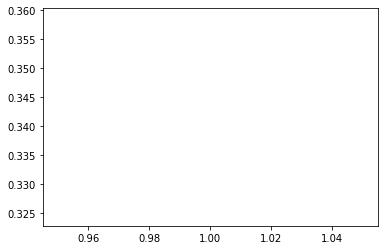

running loss =>  0.14982974961880716


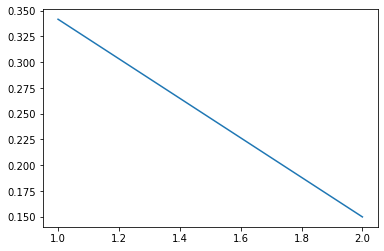

running loss =>  0.11704994569863042


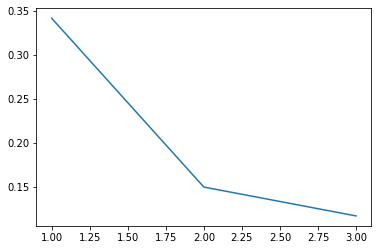

running loss =>  0.10405685952914659


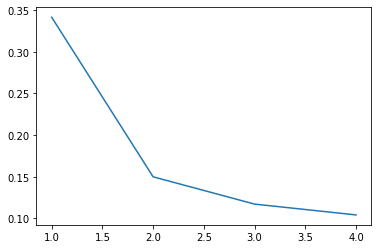

running loss =>  0.0968071642101452


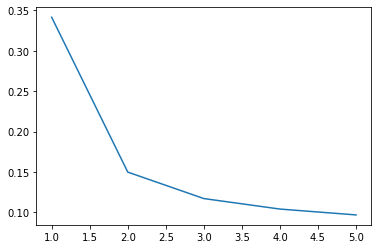

running loss =>  0.08845256200881414


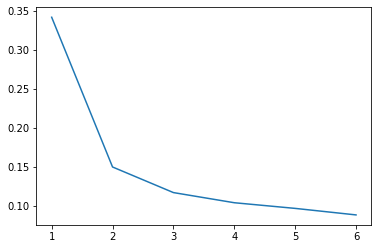

running loss =>  0.08490130105005797


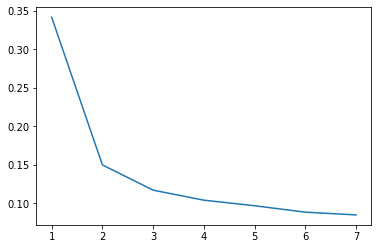

running loss =>  0.07953284035927506


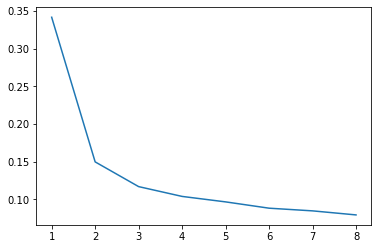

running loss =>  0.07618497824797066


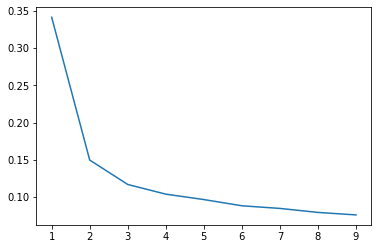

running loss =>  0.07694380850561204


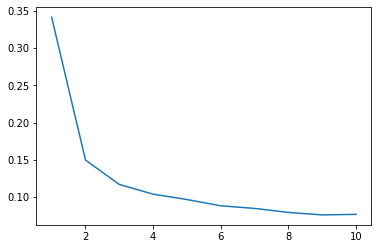

running loss =>  0.07248452297782385


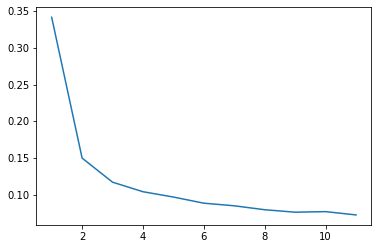

running loss =>  0.06924219717902522


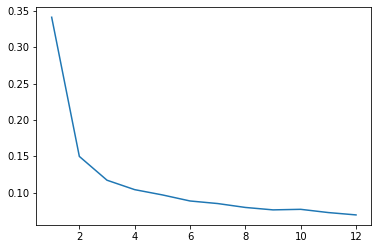

running loss =>  0.06663627722250517


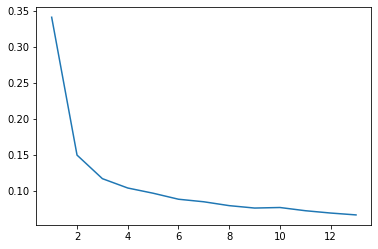

running loss =>  0.06427704667051633


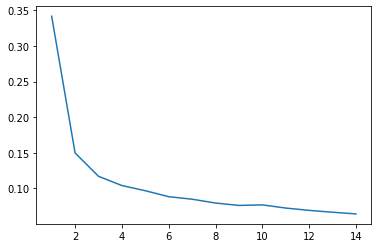

running loss =>  0.06306646676153264


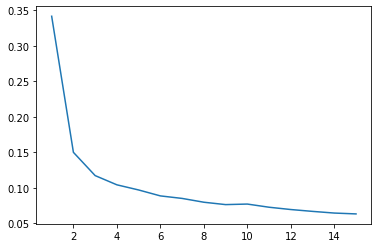

running loss =>  0.058225839969611934


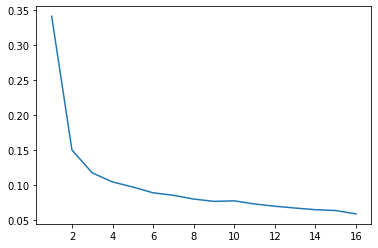

running loss =>  0.05912601619317968


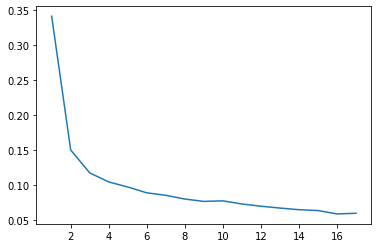

running loss =>  0.059557689894591606


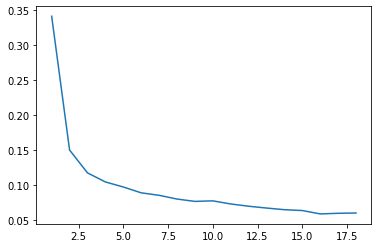

running loss =>  0.055064054185985235


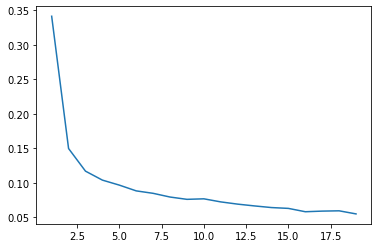

running loss =>  0.05823637020363603


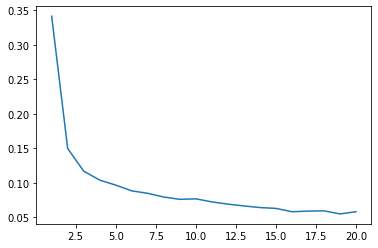

In [0]:
net = train(net, train_loader=train_loader, num_epoch=20, lr=1e-3, with_graph=True, save_=True)

In [0]:
def train(net, train_loader, num_epoch, lr, PATH=PATH, with_graph=False, save_=False):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    loss_l2 = nn.MSELoss()
    alpha = 0.01
    beta = 0.0000002
    
    j = 21
    j_list = []
    loss_list = []
    
    for epoch in range(21, 20+num_epoch+1):

        running_loss = 0.0
        loss_1 = 0.0
        loss_2 = 0.0
        loss_3 = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, label = data

            # outputs = net(inputs)

            try:
                inputs = inputs.to(device)
                label = label.to(device)


                optimizer.zero_grad()
                # outputs, A1, A2, A3, A4 = net(inputs)
                outputs = net(inputs)
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print('| WARNING: ran out of memory, retrying batch',sys.stdout)
                    sys.stdout.flush()
                    for p in net.parameters():
                        if p.grad is not None:
                            del p.grad  # free some memory
                    torch.cuda.empty_cache()
                    inputs = inputs.to(device)
                    label = label.to(device)

                    optimizer.zero_grad()
                    # outputs, A1, A2, A3, A4 = net(inputs)
                    outputs = net(inputs)
                else:
                    raise e

            loss1 = criterion(outputs, label.squeeze().long())
            # loss2 = 0.0
            # loss3 = 0.0
            outputs = outputs.data.cpu().numpy()
            # for d in range(outputs.shape[0]):
            #     loss3 += loss_l2(A1[d][0], A2[d][0]) + loss_l2(A2[d][0], A3[d][0]) + loss_l2(A3[d], A4[d])
            #     pred = outputs[d][0]
            #     pred = np.argmax(pred, axis=0)
            #     pred = pred.astype(np.uint8)
            #     pred = pred*255.
            #     lbl = label.data[d].cpu().numpy()[0]
            #     intersection = ((pred==255.) & (lbl*255.==255.)).sum()
            #     union = ((pred==255.) | (lbl*255.==255.)).sum()
            #     if union == 0:
            #         continue
            #     loss2 += (1-(intersection/union))
            # loss2 /=outputs.shape[0]
            # loss3 /=outputs.shape[0]
            # print(1)
            # abc = label[d][0]
            # print(abc.size())
            
            # print(2)
            # loss = 100*loss1 + alpha*loss2 + beta*loss3
            # print(3)
            loss = loss1
            # loss_1+= loss1.item()
            # loss_2+= alpha*loss2.item()
            # loss_3+= beta*loss3.item()
            # print(loss.item(), loss1.item(), loss2.item(), alpha*loss3.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # print(running_loss)
        
        running_loss /= len(train_loader)
        # loss_1 /= len(train_loader)
        # loss_2 /= len(train_loader)
        # loss_3 /= len(train_loader)
        # print('running loss => ', running_loss, 'loss_1', loss_1, 'loss_2', loss_2, 'loss_3', loss_3)
        print('running loss => ', running_loss)
        j+=1
        if with_graph:
            j_list.append(j)
            loss_list.append(running_loss)
            plt.plot(j_list, loss_list)
            plt.pause(0.00001)

        if save_ and epoch%5==0:
            torch.save(net.state_dict(), '/content/drive/My Drive/ENet_SAD_Models/ENet'+str(epoch)+'.pt')
            # print('test accuracy ==> ' ,calculate_accuracy(net, 0.79, img_dir_test, img_dir_test_label))

    #     print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
    torch.save(net.state_dict(), PATH)
    return net

running loss =>  0.04346145128691068


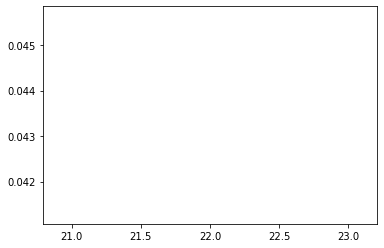

running loss =>  0.04117624075101909


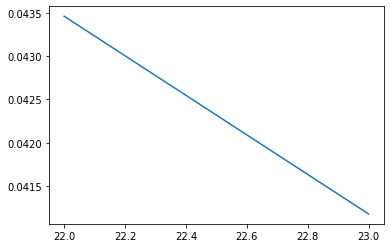

running loss =>  0.04073840071276952


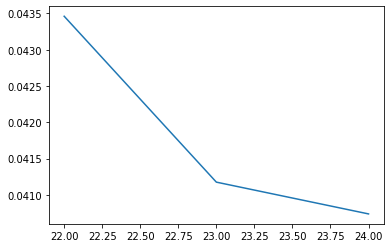

running loss =>  0.03924705264388874


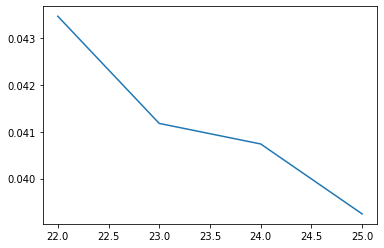

running loss =>  0.03895383318185165


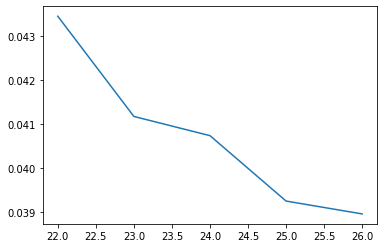

running loss =>  0.0386765205691899


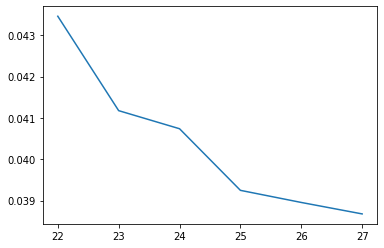

running loss =>  0.03791691999762289


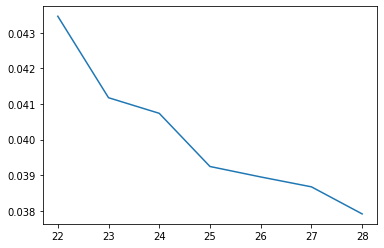

running loss =>  0.037218489594036536


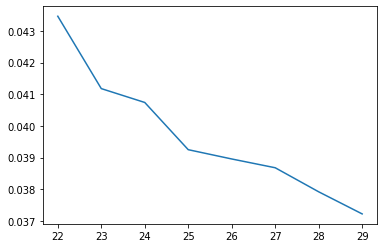

running loss =>  0.03677135808092932


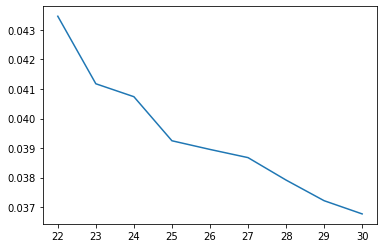

running loss =>  0.03603059339827748


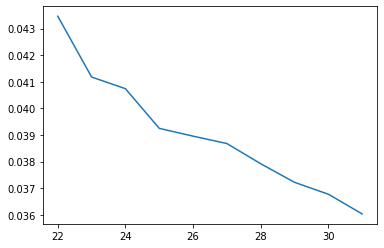

running loss =>  0.03616471410358465


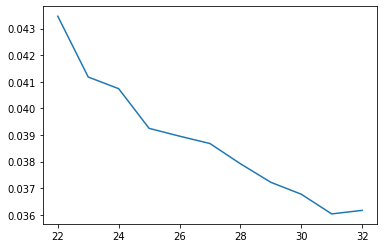

running loss =>  0.035314164995666475


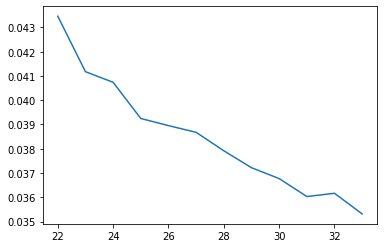

running loss =>  0.03473596675421602


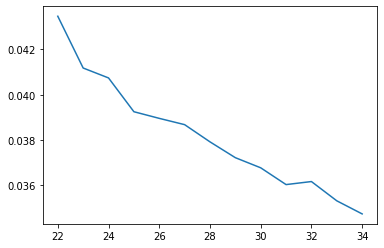

running loss =>  0.03438447371766131


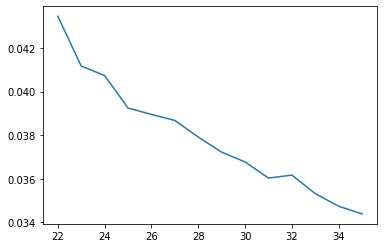

running loss =>  0.03426849082993564


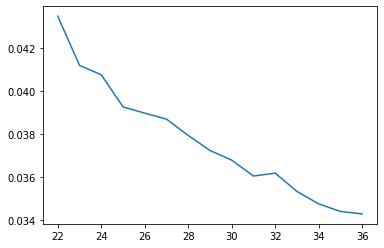

running loss =>  0.03324326444216954


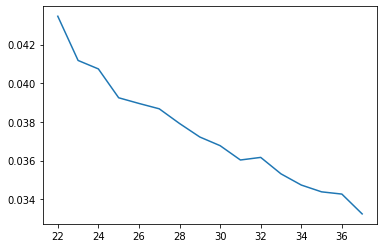

running loss =>  0.03309663613477061


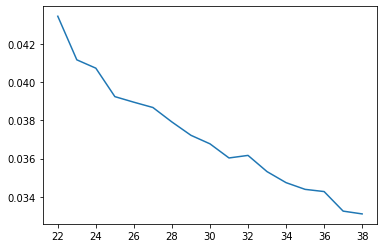

running loss =>  0.03301520956059297


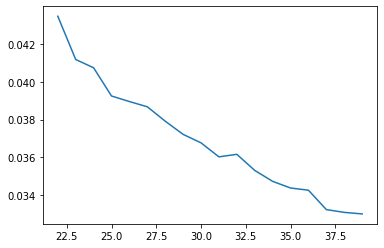

running loss =>  0.03283090044253616


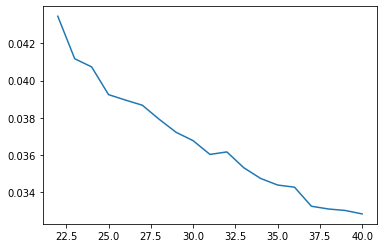

running loss =>  0.0319998400105584


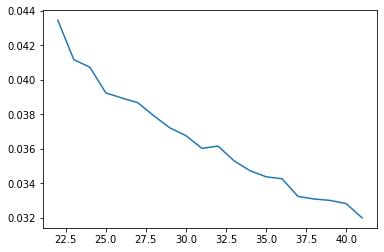

In [0]:
net = train(net, train_loader=train_loader, num_epoch=20, lr=1e-4, with_graph=True, save_=True)

In [0]:
def train(net, train_loader, num_epoch, lr, PATH=PATH, with_graph=False, save_=False):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    loss_l2 = nn.MSELoss()
    alpha = 0.01
    beta = 0.0000002
    
    j = 41
    j_list = []
    loss_list = []
    
    for epoch in range(41, 40+num_epoch+1):

        running_loss = 0.0
        loss_1 = 0.0
        loss_2 = 0.0
        loss_3 = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, label = data

            # outputs = net(inputs)

            try:
                inputs = inputs.to(device)
                label = label.to(device)


                optimizer.zero_grad()
                # outputs, A1, A2, A3, A4 = net(inputs)
                outputs = net(inputs)
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print('| WARNING: ran out of memory, retrying batch',sys.stdout)
                    sys.stdout.flush()
                    for p in net.parameters():
                        if p.grad is not None:
                            del p.grad  # free some memory
                    torch.cuda.empty_cache()
                    inputs = inputs.to(device)
                    label = label.to(device)

                    optimizer.zero_grad()
                    # outputs, A1, A2, A3, A4 = net(inputs)
                    outputs = net(inputs)
                else:
                    raise e

            loss1 = criterion(outputs, label.squeeze().long())
            # loss2 = 0.0
            # loss3 = 0.0
            outputs = outputs.data.cpu().numpy()
            # for d in range(outputs.shape[0]):
            #     loss3 += loss_l2(A1[d][0], A2[d][0]) + loss_l2(A2[d][0], A3[d][0]) + loss_l2(A3[d], A4[d])
            #     pred = outputs[d][0]
            #     pred = np.argmax(pred, axis=0)
            #     pred = pred.astype(np.uint8)
            #     pred = pred*255.
            #     lbl = label.data[d].cpu().numpy()[0]
            #     intersection = ((pred==255.) & (lbl*255.==255.)).sum()
            #     union = ((pred==255.) | (lbl*255.==255.)).sum()
            #     if union == 0:
            #         continue
            #     loss2 += (1-(intersection/union))
            # loss2 /=outputs.shape[0]
            # loss3 /=outputs.shape[0]
            # print(1)
            # abc = label[d][0]
            # print(abc.size())
            
            # print(2)
            # loss = 100*loss1 + alpha*loss2 + beta*loss3
            # print(3)
            loss = loss1
            # loss_1+= loss1.item()
            # loss_2+= alpha*loss2.item()
            # loss_3+= beta*loss3.item()
            # print(loss.item(), loss1.item(), loss2.item(), alpha*loss3.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # print(running_loss)
        
        running_loss /= len(train_loader)
        # loss_1 /= len(train_loader)
        # loss_2 /= len(train_loader)
        # loss_3 /= len(train_loader)
        # print('running loss => ', running_loss, 'loss_1', loss_1, 'loss_2', loss_2, 'loss_3', loss_3)
        print('running loss => ', running_loss)
        j+=1
        if with_graph:
            j_list.append(j)
            loss_list.append(running_loss)
            plt.plot(j_list, loss_list)
            plt.pause(0.00001)

        if save_ and epoch%5==0:
            torch.save(net.state_dict(), '/content/drive/My Drive/ENet_Models/ENet'+str(epoch)+'.pt')
            # print('test accuracy ==> ' ,calculate_accuracy(net, 0.79, img_dir_test, img_dir_test_label))

    #     print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
    torch.save(net.state_dict(), PATH)
    return net

running loss =>  0.03172129861289455


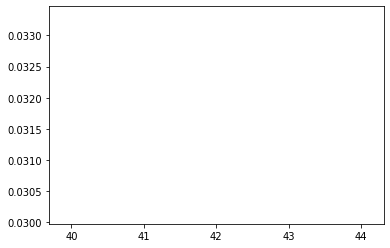

running loss =>  0.03123432590115455


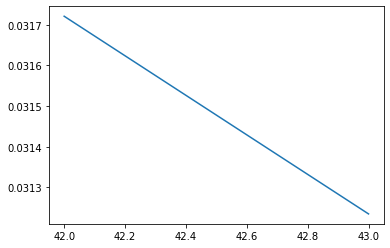

running loss =>  0.03127324551103577


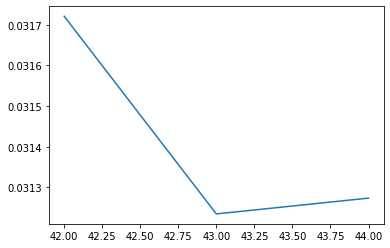

running loss =>  0.03100057699347055


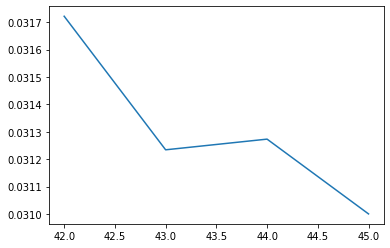

running loss =>  0.0308837568968214


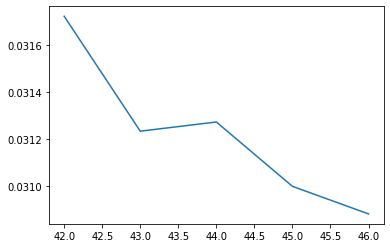

running loss =>  0.030866146307959353


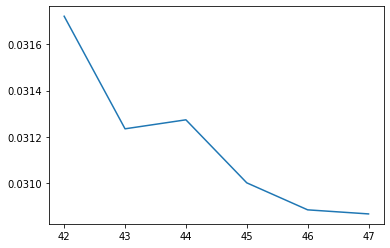

running loss =>  0.030492071563037494


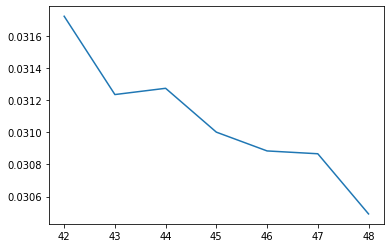

running loss =>  0.030290280639003683


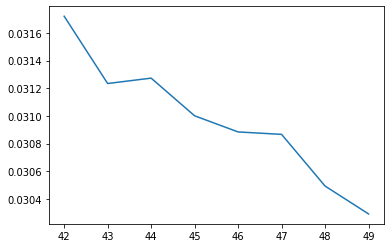

running loss =>  0.030187728985022474


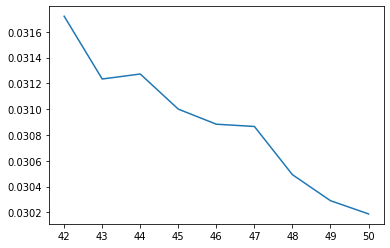

running loss =>  0.029904249114214732


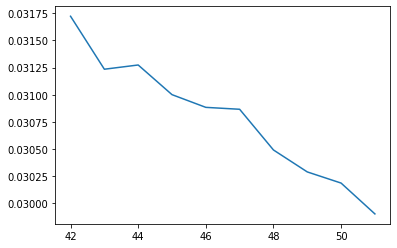

running loss =>  0.02980865598205597


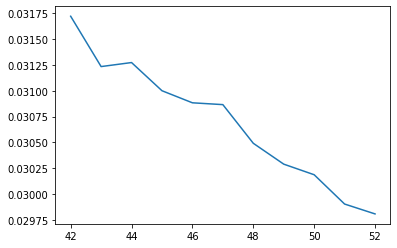

running loss =>  0.029735805126287602


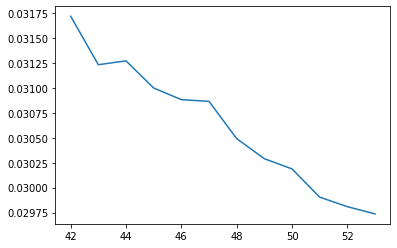

running loss =>  0.0293708394772263


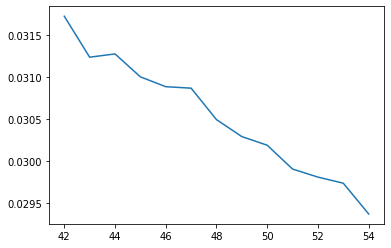

running loss =>  0.029147896174621837


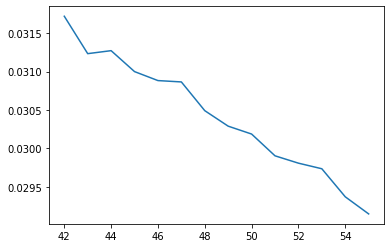

running loss =>  0.029333795791351668


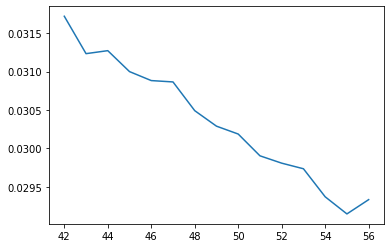

running loss =>  0.029090502329411044


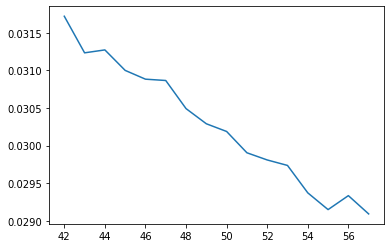

running loss =>  0.028900473829238646


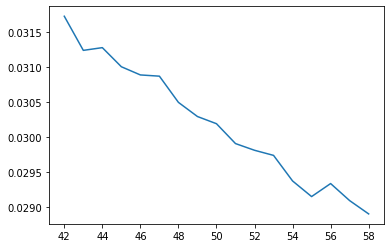

running loss =>  0.028699614027495025


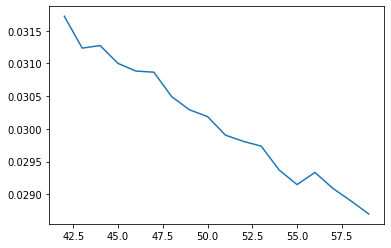

running loss =>  0.028613623492019152


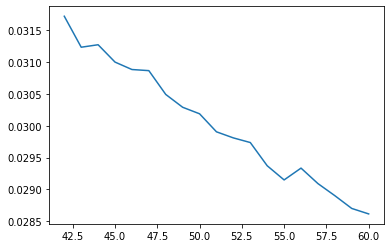

running loss =>  0.028347781048186364


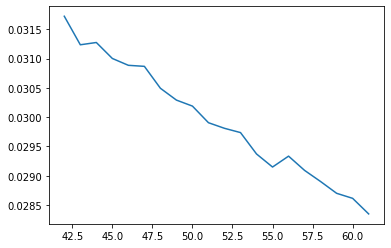

In [0]:
net = train(net, train_loader=train_loader, num_epoch=20, lr=5e-5, with_graph=True, save_=True)

In [0]:
def train(net, train_loader, num_epoch, lr, PATH=PATH, with_graph=False, save_=False):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    loss_l2 = nn.MSELoss()
    alpha = 0.01
    beta = 0.0000002
    
    j = 61
    j_list = []
    loss_list = []
    
    for epoch in range(61, 60+num_epoch+1):

        running_loss = 0.0
        loss_1 = 0.0
        loss_2 = 0.0
        loss_3 = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, label = data

            # outputs = net(inputs)

            try:
                inputs = inputs.to(device)
                label = label.to(device)


                optimizer.zero_grad()
                # outputs, A1, A2, A3, A4 = net(inputs)
                outputs = net(inputs)
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print('| WARNING: ran out of memory, retrying batch',sys.stdout)
                    sys.stdout.flush()
                    for p in net.parameters():
                        if p.grad is not None:
                            del p.grad  # free some memory
                    torch.cuda.empty_cache()
                    inputs = inputs.to(device)
                    label = label.to(device)

                    optimizer.zero_grad()
                    # outputs, A1, A2, A3, A4 = net(inputs)
                    outputs = net(inputs)
                else:
                    raise e

            loss1 = criterion(outputs, label.squeeze().long())
            # loss2 = 0.0
            # loss3 = 0.0
            outputs = outputs.data.cpu().numpy()
            # for d in range(outputs.shape[0]):
            #     loss3 += loss_l2(A1[d][0], A2[d][0]) + loss_l2(A2[d][0], A3[d][0]) + loss_l2(A3[d], A4[d])
            #     pred = outputs[d][0]
            #     pred = np.argmax(pred, axis=0)
            #     pred = pred.astype(np.uint8)
            #     pred = pred*255.
            #     lbl = label.data[d].cpu().numpy()[0]
            #     intersection = ((pred==255.) & (lbl*255.==255.)).sum()
            #     union = ((pred==255.) | (lbl*255.==255.)).sum()
            #     if union == 0:
            #         continue
            #     loss2 += (1-(intersection/union))
            # loss2 /=outputs.shape[0]
            # loss3 /=outputs.shape[0]
            # print(1)
            # abc = label[d][0]
            # print(abc.size())
            
            # print(2)
            # loss = 100*loss1 + alpha*loss2 + beta*loss3
            # print(3)
            loss = loss1
            # loss_1+= loss1.item()
            # loss_2+= alpha*loss2.item()
            # loss_3+= beta*loss3.item()
            # print(loss.item(), loss1.item(), loss2.item(), alpha*loss3.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # print(running_loss)
        
        running_loss /= len(train_loader)
        # loss_1 /= len(train_loader)
        # loss_2 /= len(train_loader)
        # loss_3 /= len(train_loader)
        # print('running loss => ', running_loss, 'loss_1', loss_1, 'loss_2', loss_2, 'loss_3', loss_3)
        print('running loss => ', running_loss)
        j+=1
        if with_graph:
            j_list.append(j)
            loss_list.append(running_loss)
            plt.plot(j_list, loss_list)
            plt.pause(0.00001)

        if save_ and epoch%5==0:
            torch.save(net.state_dict(), '/content/drive/My Drive/ENet_SAD_Models/ENet'+str(epoch)+'.pt')
            # print('test accuracy ==> ' ,calculate_accuracy(net, 0.79, img_dir_test, img_dir_test_label))

    #     print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
    torch.save(net.state_dict(), PATH)
    return net

running loss =>  0.02808234393997218


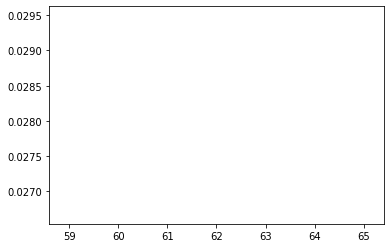

running loss =>  0.027960626188144887


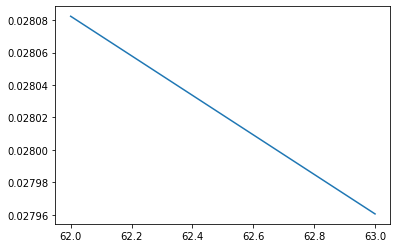

running loss =>  0.027973632939079757


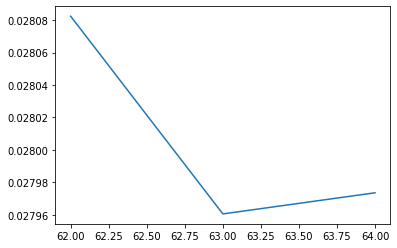

running loss =>  0.027887222827762684


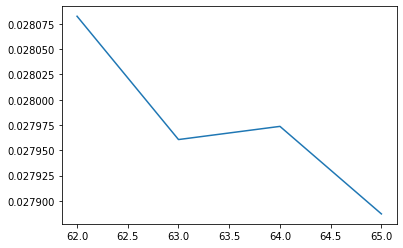

running loss =>  0.028043929367296157


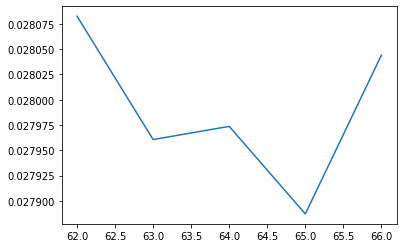

running loss =>  0.027959917041082537


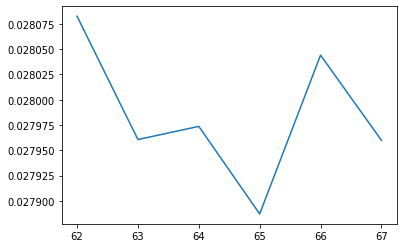

running loss =>  0.027989101025366014


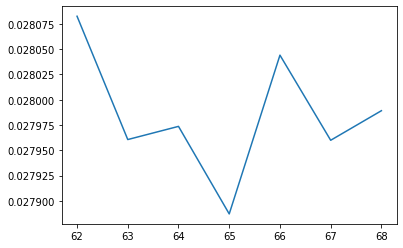

running loss =>  0.02793550721660096


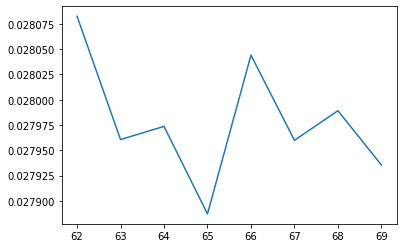

running loss =>  0.027823918208640108


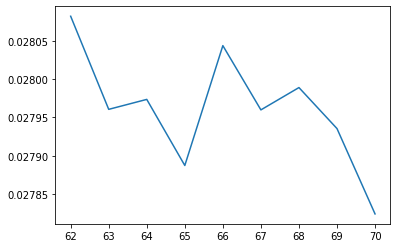

running loss =>  0.027799577061687748


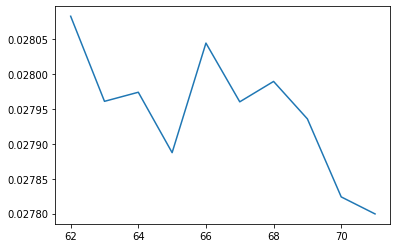

running loss =>  0.02760589547375197


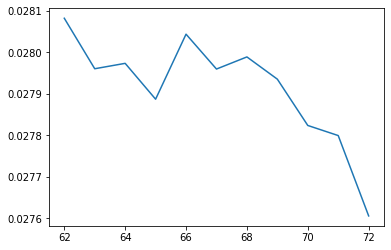

running loss =>  0.027713687569704108


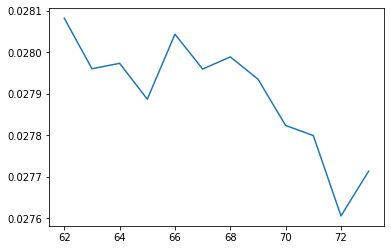

running loss =>  0.027666729244012988


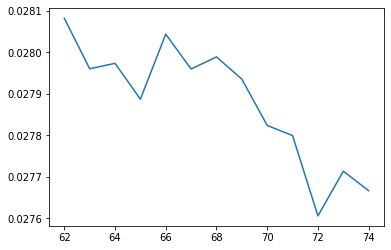

running loss =>  0.02765193665700574


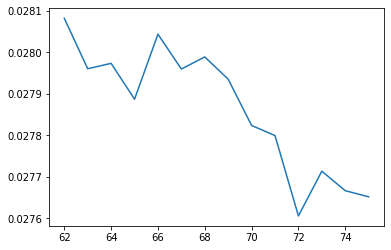

running loss =>  0.027780228624901464


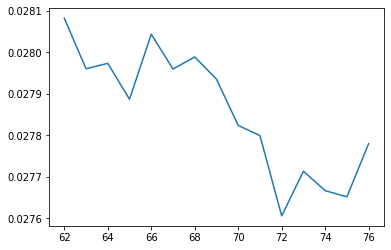

running loss =>  0.02750778566765529


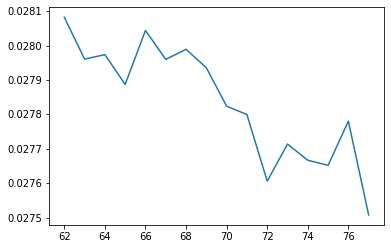

running loss =>  0.02757727627151756


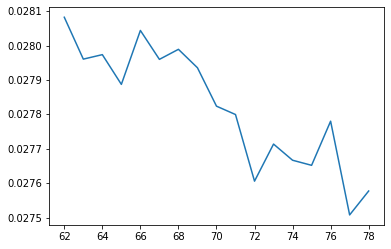

running loss =>  0.027573041878240084


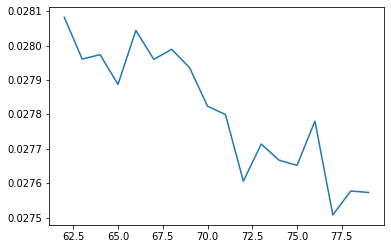

running loss =>  0.02753924332078426


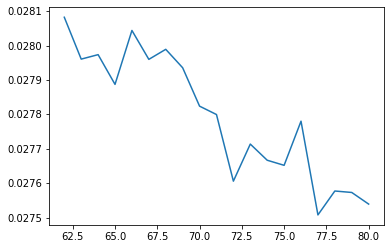

running loss =>  0.027397686495415626


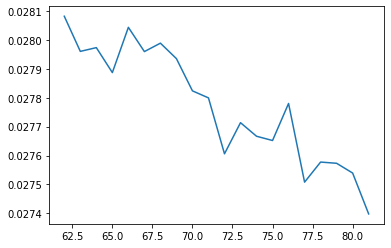

In [0]:
net = train(net, train_loader=train_loader, num_epoch=20, lr=1e-5, with_graph=True, save_=True)

In [0]:
def train(net, train_loader, num_epoch, lr, PATH=PATH, with_graph=False, save_=False):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    loss_l2 = nn.MSELoss()
    alpha = 0.01
    beta = 0.0000002
    
    j = 81
    j_list = []
    loss_list = []
    
    for epoch in range(81, 80+num_epoch+1):

        running_loss = 0.0
        loss_1 = 0.0
        loss_2 = 0.0
        loss_3 = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, label = data

            # outputs = net(inputs)

            try:
                inputs = inputs.to(device)
                label = label.to(device)


                optimizer.zero_grad()
                # outputs, A1, A2, A3, A4 = net(inputs)
                outputs = net(inputs)
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print('| WARNING: ran out of memory, retrying batch',sys.stdout)
                    sys.stdout.flush()
                    for p in net.parameters():
                        if p.grad is not None:
                            del p.grad  # free some memory
                    torch.cuda.empty_cache()
                    inputs = inputs.to(device)
                    label = label.to(device)

                    optimizer.zero_grad()
                    # outputs, A1, A2, A3, A4 = net(inputs)
                    outputs = net(inputs)
                else:
                    raise e

            loss1 = criterion(outputs, label.squeeze().long())
            # loss2 = 0.0
            loss3 = 0.0
            outputs = outputs.data.cpu().numpy()
            # for d in range(outputs.shape[0]):
            #     loss3 += loss_l2(A1[d][0], A2[d][0]) + loss_l2(A2[d][0], A3[d][0]) + loss_l2(A3[d], A4[d])
            #     pred = outputs[d][0]
            #     pred = np.argmax(pred, axis=0)
            #     pred = pred.astype(np.uint8)
            #     pred = pred*255.
            #     lbl = label.data[d].cpu().numpy()[0]
            #     intersection = ((pred==255.) & (lbl*255.==255.)).sum()
            #     union = ((pred==255.) | (lbl*255.==255.)).sum()
            #     if union == 0:
            #         continue
            #     loss2 += (1-(intersection/union))
            # loss2 /=outputs.shape[0]
            # loss3 /=outputs.shape[0]
            # print(1)
            # abc = label[d][0]
            # print(abc.size())
            
            # print(2)
            # loss = 100*loss1 + alpha*loss2 + beta*loss3
            # print(3)
            loss = loss1
            # loss_1+= loss1.item()
            # loss_2+= alpha*loss2.item()
            # loss_3+= beta*loss3.item()
            # print(loss.item(), loss1.item(), loss2.item(), alpha*loss3.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # print(running_loss)
        
        running_loss /= len(train_loader)
        loss_1 /= len(train_loader)
        # loss_2 /= len(train_loader)
        # loss_3 /= len(train_loader)
        print('running loss => ', running_loss, 'loss_1', loss_1, 'loss_3', loss_3)
        # print('running loss => ', running_loss)
        j+=1
        if with_graph:
            j_list.append(j)
            loss_list.append(running_loss)
            plt.plot(j_list, loss_list)
            plt.pause(0.00001)

        if save_ and epoch%5==0:
            torch.save(net.state_dict(), '/content/drive/My Drive/ENet_SAD_Models/ENet'+str(epoch)+'.pt')
            # print('test accuracy ==> ' ,calculate_accuracy(net, 0.79, img_dir_test, img_dir_test_label))

    #     print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
    torch.save(net.state_dict(), PATH)
    return net

running loss =>  0.026388996591170628


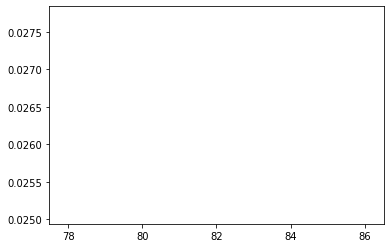

running loss =>  0.02619396522641182


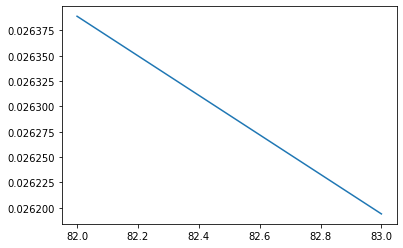

running loss =>  0.026220443588431164


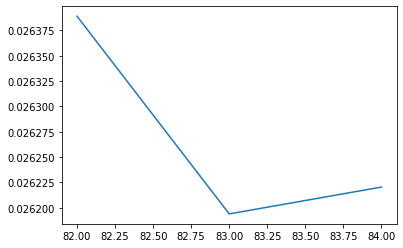

running loss =>  0.026033656551472602


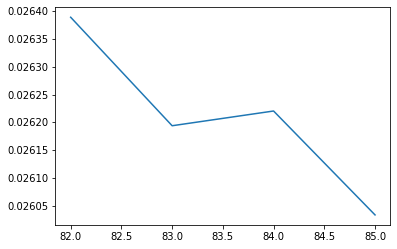

running loss =>  0.026101547663891188


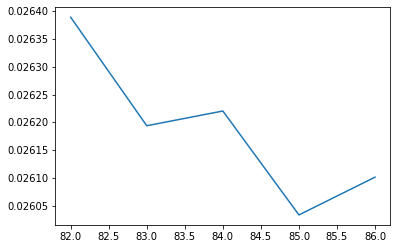

running loss =>  0.026163745671510696


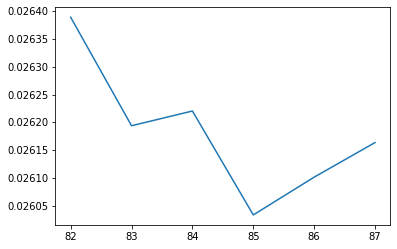

running loss =>  0.026107373477150034


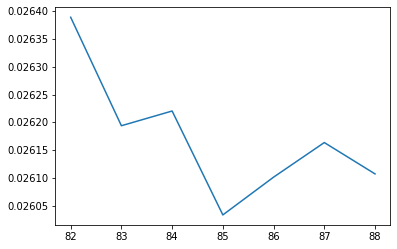

running loss =>  0.02624146095527116


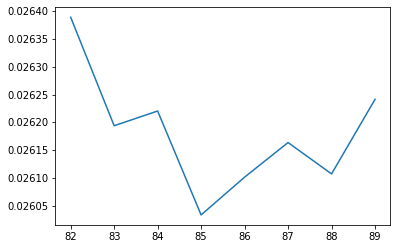

running loss =>  0.026126831970227662


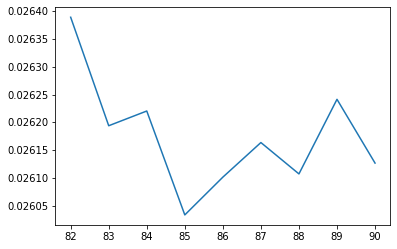

running loss =>  0.02617666838310098


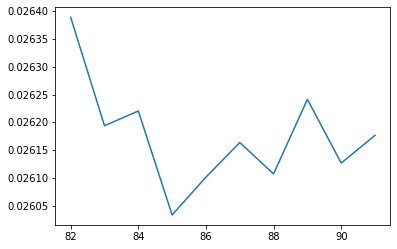

running loss =>  0.026208796748711218


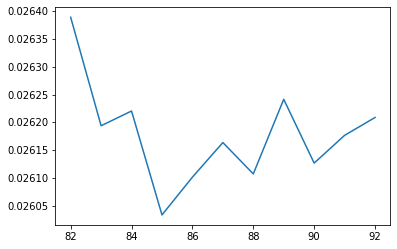

running loss =>  0.026185667923381253


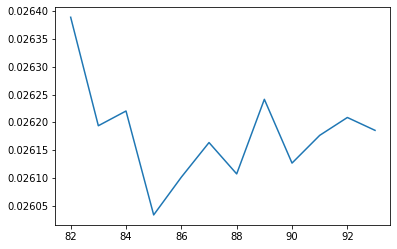

running loss =>  0.02623377982727302


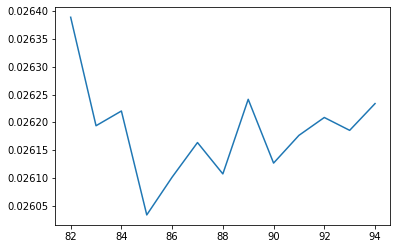

running loss =>  0.026070302031854148


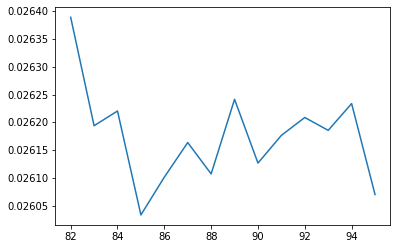

running loss =>  0.026289372574738276


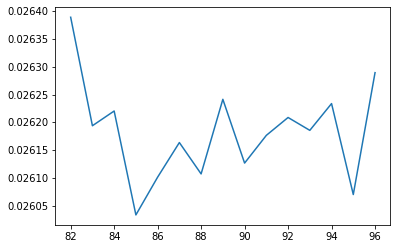

running loss =>  0.026356064063566987


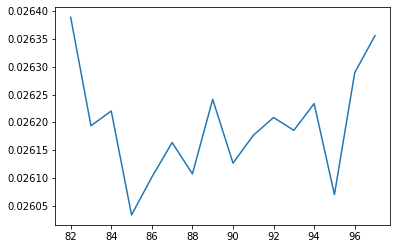

running loss =>  0.02620629040944961


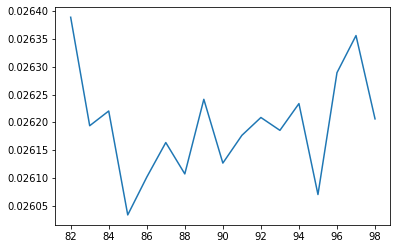

running loss =>  0.026155675110477273


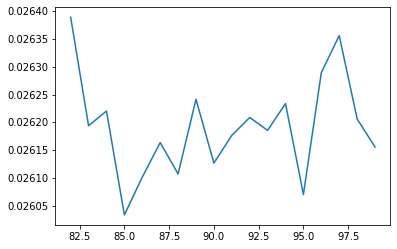

running loss =>  0.026288978054478603


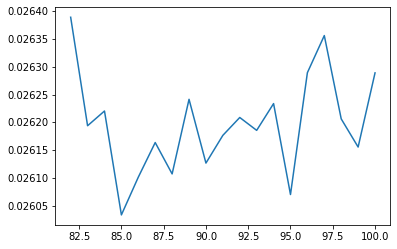

running loss =>  0.0261734663759188


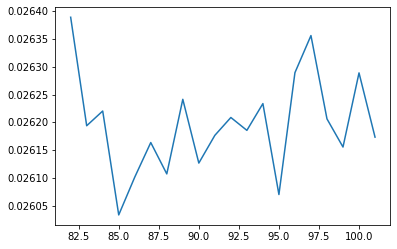

In [0]:
net = ENet(C=2)
net.load_state_dict(torch.load('/content/drive/My Drive/ENet_Models/ENet_attention1.pt'))
# net.eval()
net = net.to(device)
net = train(net, train_loader=train_loader, num_epoch=20, lr=1e-7, with_graph=True, save_=True)

In [0]:
def train(net, train_loader, num_epoch, lr, PATH=PATH, with_graph=False, save_=False):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    loss_l2 = nn.MSELoss()
    alpha = 0.01
    beta = 10
    
    j = 81
    j_list = []
    loss_list = []
    
    for epoch in range(80, 80+num_epoch+1):

        running_loss = 0.0
        loss_1 = 0.0
        loss_2 = 0.0
        loss_3 = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, label = data

            # outputs = net(inputs)

            try:
                inputs = inputs.to(device)
                label = label.to(device)


                optimizer.zero_grad()
                outputs, A1, A2, A3, A4 = net(inputs)
                # outputs = net(inputs)
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print('| WARNING: ran out of memory, retrying batch',sys.stdout)
                    sys.stdout.flush()
                    for p in net.parameters():
                        if p.grad is not None:
                            del p.grad  # free some memory
                    torch.cuda.empty_cache()
                    inputs = inputs.to(device)
                    label = label.to(device)

                    optimizer.zero_grad()
                    outputs, A1, A2, A3, A4 = net(inputs)
                    # outputs = net(inputs)
                else:
                    raise e
            # print(A1[0][0])
            loss1 = criterion(outputs, label.squeeze().long())
            # loss2 = 0.0
            loss3 = 0.0
            # outputs = outputs.data.cpu().numpy()
            # for d in range(outputs.shape[0]):
                # print(A1.size(), ' ', A2.size())
                # loss3 += loss_l2(A1[d][0], A2[d][0]) + loss_l2(A2[d][0], A3[d][0]) + loss_l2(A3[d][0], A4[d][0])
                # pred = outputs[d][0]
                # pred = np.argmax(pred, axis=0)
                # pred = pred.astype(np.uint8)
                # pred = pred*255.
                # lbl = label.data[d].cpu().numpy()[0]
                # intersection = ((pred==255.) & (lbl*255.==255.)).sum()
                # union = ((pred==255.) | (lbl*255.==255.)).sum()
                # if union == 0:
                    # continue
                # loss2 += (1-(intersection/union))
            # loss2 /=outputs.shape[0]
            # print(loss3.item())
            loss3 = loss_l2(A1, A2) + loss_l2(A2, A3) + loss_l2(A3, A4)
            loss3 /=outputs.shape[0]
            # print(1)
            # abc = label[d][0]
            # print(abc.size())
            
            # print(2)
            loss = loss1 + beta*loss3
            # print(3)
            # loss = loss1
            loss_1+= loss1.item()
            loss_3+= beta*loss3.item()
            # print(loss.item(), loss1.item(), loss2.item(), alpha*loss3.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # print(running_loss)
        
        running_loss /= len(train_loader)
        loss_1 /= len(train_loader)
        # loss_2 /= len(train_loader)
        loss_3 /= len(train_loader)
        print('running loss => ', running_loss, 'loss_1', loss_1, 'loss_3', loss_3)
        # print('running loss => ', running_loss)
        j+=1
        if with_graph:
            j_list.append(j)
            loss_list.append(running_loss)
            plt.plot(j_list, loss_list)
            plt.pause(0.00001)

        if save_ and epoch%5==0:
            torch.save(net.state_dict(), '/content/drive/My Drive/Exp1/exp_1_'+str(epoch)+'.pt')
            # print('test accuracy ==> ' ,calculate_accuracy(net, 0.79, img_dir_test, img_dir_test_label))

    #     print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
    torch.save(net.state_dict(), PATH)
    return net

In [0]:
net = ENet(C=2)
net.load_state_dict(torch.load('/content/drive/My Drive/ENet_SAD_Models/ENet100.pt'))
# net.eval()
net = net.to(device)
# net = train(net, train_loader=train_loader, num_epoch=20, lr=1e-20, with_graph=True, save_=True)

In [0]:
#### Function to normalise
def norm(vector):
    min_v = torch.min(vector)
    range_v = torch.max(vector) - min_v
    if range_v > 0:
        normalised = (vector - min_v) / range_v
    else:
        normalised = torch.zeros(vector.size())
    return normalised

#### Testing Function
def predict_image(image):
    image_tensor = transform_test(image)
    image_tensor = image_tensor.unsqueeze(0)
    inputs = Variable(image_tensor)
    inputs = inputs.to(device)
    # net = torch.load('/content/drive/My Drive/ENet_Models/ENet80.pt')
    # net = ENet(C=2)
    # net.load_state_dict(torch.load('/content/drive/My Drive/ENet_Models/ENet_attention1.pt'))
    # net.eval()
    # net = net.to(device)
    output = net(inputs.to(device))
    return output

In [0]:
#### Test

def test(img_test_dir, prob):
    out = norm(predict_image(Image.open(img_test_dir))[0]).cpu().detach().numpy()*255
    print(out)
    img = cv.imread(img_test_dir, 1)
    a, b, c = img.shape

    out = cv.resize(out, (b,a))
    
    mask = np.zeros(out.shape)
    for i in range(len(out)):
        for j in range(len(out[0])):
            if out[i,j] > prob*255.:
                img[i,j][1] = 255
                img[i,j][0] = 0
                img[i,j][2] = 0
                mask[i,j] = 255
                
    return mask, img

In [0]:
img_test_dir = '/content/drive/My Drive/New_City/cityscapes/test/berlin/berlin_000030_000019_leftImg8bit.png'
mask, img = test(img_test_dir, 0.6)
from google.colab.patches import cv2_imshow
cv2_imshow(img)

[[[[142.42383  136.58275  146.88612  ... 136.94395  151.99886
    137.40512 ]
   [152.17738  148.39485  156.47708  ... 155.18468  158.78632
    144.22964 ]
   [154.12868  154.45918  149.99872  ... 164.11148  147.85394
    137.36658 ]
   ...
   [130.86276  115.33711   98.143005 ... 106.66172  123.30701
    128.92035 ]
   [130.32646  117.612854  95.07684  ... 106.38166  118.03901
    125.75012 ]
   [123.07918  111.908295  95.19172  ... 105.86997  111.471375
    121.48491 ]]

  [[ 86.08744   73.21777   80.68447  ...  79.213486  80.10806
     89.13833 ]
   [ 86.18493   72.778145  74.839165 ...  78.81984   86.23257
     87.83572 ]
   [ 75.41359   76.71071   74.943886 ...  56.34579   79.95327
     89.66662 ]
   ...
   [101.45574  110.37227  126.58203  ... 132.62311  112.92404
    103.4996  ]
   [ 98.23687  112.336494 131.66028  ... 125.72368  114.50478
    107.69332 ]
   [107.65816  109.981865 118.849205 ... 123.07702  115.372055
    107.62271 ]]]]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


error: ignored

In [0]:
def train_atten(net, train_loader, num_epoch, lr, PATH=PATH, with_graph=False, save_=False):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0)
    loss_l2 = nn.MSELoss()
    alpha = 0.01
    beta = 0.0000002
    
    j = 61
    j_list = []
    loss_list = []
    
    for epoch in range(61, 60+num_epoch+1):

        running_loss = 0.0
        loss_1 = 0.0
        loss_2 = 0.0
        loss_3 = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, label = data

            # outputs = net(inputs)

            try:
                inputs = inputs.to(device)
                label = label.to(device)


                optimizer.zero_grad()
                # outputs, A1, A2, A3, A4 = net(inputs)
                outputs = net(inputs)
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print('| WARNING: ran out of memory, retrying batch',sys.stdout)
                    sys.stdout.flush()
                    for p in net.parameters():
                        if p.grad is not None:
                            del p.grad  # free some memory
                    torch.cuda.empty_cache()
                    inputs = inputs.to(device)
                    label = label.to(device)

                    optimizer.zero_grad()
                    # outputs, A1, A2, A3, A4 = net(inputs)
                    outputs = net(inputs)
                else:
                    raise e

            loss1 = criterion(outputs, label.squeeze().long())
            # loss2 = 0.0
            # loss3 = 0.0
            outputs = outputs.data.cpu().numpy()
            # for d in range(outputs.shape[0]):
            #     loss3 += loss_l2(A1[d][0], A2[d][0]) + loss_l2(A2[d][0], A3[d][0]) + loss_l2(A3[d], A4[d])
            #     pred = outputs[d][0]
            #     pred = np.argmax(pred, axis=0)
            #     pred = pred.astype(np.uint8)
            #     pred = pred*255.
            #     lbl = label.data[d].cpu().numpy()[0]
            #     intersection = ((pred==255.) & (lbl*255.==255.)).sum()
            #     union = ((pred==255.) | (lbl*255.==255.)).sum()
            #     if union == 0:
            #         continue
            #     loss2 += (1-(intersection/union))
            # loss2 /=outputs.shape[0]
            # loss3 /=outputs.shape[0]
            # print(1)
            # abc = label[d][0]
            # print(abc.size())
            
            # print(2)
            # loss = 100*loss1 + alpha*loss2 + beta*loss3
            # print(3)
            loss = loss1
            # loss_1+= loss1.item()
            # loss_2+= alpha*loss2.item()
            # loss_3+= beta*loss3.item()
            # print(loss.item(), loss1.item(), loss2.item(), alpha*loss3.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # print(running_loss)
        
        running_loss /= len(train_loader)
        # loss_1 /= len(train_loader)
        # loss_2 /= len(train_loader)
        # loss_3 /= len(train_loader)
        # print('running loss => ', running_loss, 'loss_1', loss_1, 'loss_2', loss_2, 'loss_3', loss_3)
        print('running loss => ', running_loss)
        j+=1
        if with_graph:
            j_list.append(j)
            loss_list.append(running_loss)
            plt.plot(j_list, loss_list)
            plt.pause(0.00001)

        # if save_ and epoch%5==0:
            # torch.save(net, '/content/drive/My Drive/ENet_Models/ENet'+str(epoch)+'.pt')
        torch.save(net.state_dict(), '/content/drive/My Drive/ENet_Models/ENet_attention'+str(epoch)+'.pt')
            # print('test accuracy ==> ' ,calculate_accuracy(net, 0.79, img_dir_test, img_dir_test_label))

    #     print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
    # torch.save(net, PATH)
    return net

running loss =>  0.02630047448059564


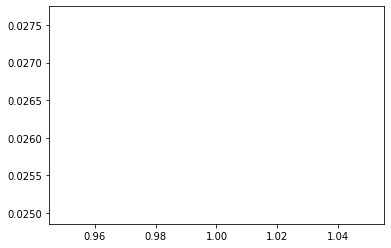

In [0]:
net = ENet(C=2)
# net = torch.load('/content/drive/My Drive/ENet_Models/ENet80.pt')
net.curnet.load_state_dict(torch.load('/content/drive/My Drive/ENet_Models/ENet80.pt'))
net.eval()
net = net.to(device)
cur = train(net, train_loader=train_loader, num_epoch=1, lr=1e-5, with_graph=True, save_=True)

In [0]:
class Attention(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        self.at_gen1 = SAD()
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.at_gen2 = SAD()
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)

        self.at_gen3 = SAD()
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.at_gen4 = SAD()
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x, with_SAD = False):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        out1 = x
        # print('A1', x.size())
        if(with_SAD):
          #first attention map
          A1 = self.at_gen1(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        out2 = x
        # print('A2', x.size())
        if(with_SAD):
          #Second attention map
          A2 = self.at_gen2(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        out3 = x
        # print('A3', x.size())
        if(with_SAD):
          #third attention map
          A3 = self.at_gen3(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        out4 = x
        # print('A4', x.size())
        if(with_SAD):
          #forth attention map
          A4 = self.at_gen4(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        if(not with_SAD):
          return x, out1, out2, out3, out4

        else:
          return x, A1, A2, A3, A4

In [0]:
curnet = Attention(C=2)
curnet.load_state_dict(torch.load('/content/drive/My Drive/ENet_SAD_Models/ENet100.pt'))
curnet.eval()
curnet = curnet.to(device)
# curnet =  curnet.to(device)
#### Function to normalise
def norm(vector):
    min_v = torch.min(vector)
    range_v = torch.max(vector) - min_v
    if range_v > 0:
        normalised = (vector - min_v) / range_v
    else:
        normalised = torch.zeros(vector.size())
    return normalised

#### Testing Function
def predict_output(image):
    image_tensor = transform_test(image)
    image_tensor = image_tensor.unsqueeze(0)
    inputs = Variable(image_tensor)
    inputs = inputs.to(device)
    # net = torch.load('/content/drive/My Drive/Models/ENet_SAD245.pt')
    # net = net.to(device)
    output, A1, A2, A3, A4 = curnet(inputs.to(device))
    return output
def predict_A1(image):
    image_tensor = transform_test(image)
    image_tensor = image_tensor.unsqueeze(0)
    inputs = Variable(image_tensor)
    inputs = inputs.to(device)
    output, A1, A2, A3, A4 = curnet(inputs.to(device))
    print('A1', A1.size())
    A1 = torch.sum(A1, dim = 1)
    print('After sum', A1.shape)
    return A1
def predict_A2(image):
    image_tensor = transform_test(image)
    image_tensor = image_tensor.unsqueeze(0)
    inputs = Variable(image_tensor)
    inputs = inputs.to(device)
    output, A1, A2, A3, A4 = curnet(inputs.to(device))
    A2 = torch.sum(A2,dim = 1)
    # print(A2.shape)
    return A2
def predict_A3(image):
    image_tensor = transform_test(image)
    image_tensor = image_tensor.unsqueeze(0)
    inputs = Variable(image_tensor)
    inputs = inputs.to(device)
    output, A1, A2, A3, A4 = curnet(inputs.to(device))
    A3 = torch.sum(A3, dim = 1)
    # print(A3.shape)
    return A3
def predict_A4(image):
    image_tensor = transform_test(image)
    image_tensor = image_tensor.unsqueeze(0)
    inputs = Variable(image_tensor)
    inputs = inputs.to(device)
    output, A1, A2, A3, A4 = curnet(inputs.to(device))
    A4 = torch.sum(A4, dim = 1)
    # print(A4.shape)
    return A4

A1 torch.Size([1, 64, 64, 128])
After sum torch.Size([1, 64, 128])
out shape (256, 512)
(64, 128)
(64, 128)


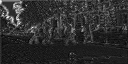

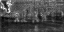

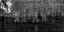

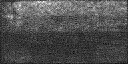

In [0]:
def test(img_test_dir, prob):
    out = norm(predict_output(Image.open(img_test_dir))[0][1]).cpu().detach().numpy()*255
    a1 = norm(predict_A1(Image.open(img_test_dir))[0]).cpu().detach().numpy()*255
    a2 = norm(predict_A2(Image.open(img_test_dir))[0]).cpu().detach().numpy()*255
    a3 = norm(predict_A3(Image.open(img_test_dir))[0]).cpu().detach().numpy()*255
    a4 = norm(predict_A4(Image.open(img_test_dir))[0]).cpu().detach().numpy()*255
    print('out shape',out.shape)
    print(a1.shape)
    img = cv.imread(img_test_dir, 1)
    # print(img.shape)
    out = cv.resize(out, (512,256))
    a_1 = cv.resize(a1, (128,64))
    a_2 = cv.resize(a2, (64,32))
    a_3 = cv.resize(a3, (64,32))
    a_4 = cv.resize(a4, (128,64))

    mask = np.zeros(out.shape)
    mask_a1 = np.zeros(out.shape)
    mask_a2 = np.zeros(out.shape)
    mask_a3 = np.zeros(out.shape)
    mask_a4 = np.zeros(out.shape)
    for i in range(len(out)):
        for j in range(len(out[0])):
            if out[i,j] > prob*255.:
                img[i,j][1] = 255
                img[i,j][0] = 0
                img[i,j][2] = 0
                mask[i,j] = 255
    # for i in range(len(a1)):
    #     for j in range(len(a1[0])):
    #         imga1[i,j] = a_1[i,j]
    #         # imga1[i,j][0] = a_1[i,j]*255
    #         # imga1[i,j][2] = a_1[i,j]*255
    #         mask_a1[i,j] = 255
    
    # for i in range(len(a2)):
    #     for j in range(len(a2[0])):
    #         # if a_2[i,j] > prob*255.:
    #         imga2[i,j] = a_2[i,j]
    #         # imga2[i,j][0] = 0
    #         # imga2[i,j][2] = 0
    #         mask_a2[i,j] = 255
    # for i in range(len(a3)):
    #     for j in range(len(a3[0])):
    #         # if a_3[i,j] > prob*255.:
    #         imga3[i,j] = a_3[i,j]
    #         # imga3[i,j][0] = 0
    #         # imga3[i,j][2] = 0
    #         mask_a3[i,j] = 255
    # for i in range(len(a4)):
    #     for j in range(len(a4[0])):
    #         imga4[i,j] = a_4[i,j]
    #         mask_a4[i,j] = 255
    
                
#     # return mask, img, mask_a1, mask_a2, mask_a3, mask_a4
#     return img, imga1, imga2, imga3, imga4
    return img, a1, a2, a3, a4

# net = Attention(C=2)
# net.load_state_dict(torch.load('/content/drive/My Drive/Models/ENet45.pt'))
# net = torch.load('/content/drive/My Drive/Models/ENet_SAD245.pt')
# model.to(device)
# net = net.to(device)
img_test_dir = '/content/drive/My Drive/New_City/cityscapes/test/berlin/berlin_000061_000019_leftImg8bit.png'
out, out1, out2, out3, out4 = test(img_test_dir, 0.88)
# print(out1.type())
print(out1.shape)
cv2_imshow(out1)
cv2_imshow(out2)
cv2_imshow(out3)
cv2_imshow(out4)

In [0]:
# def iou(net, loader, prob):
#     SMOOTH = 1e-16
#     correct = 0.0
#     total = 0.0
#     intersection = 0
#     union = 0
#     print('loader', len(loader))
#     for i, data in enumerate(loader, 0):
        
#         # print('entered')
#         inputs, label = data
#         inputs, label = inputs.to(device), label.to(device)

#         start = time.time()
#         # print('a')
#         outputs, a1, a2, a3, a4 = (net(inputs))
#         outputs = (outputs[:,1]).cpu().detach().numpy()*255.
#         # print('b')
#         end = time.time() - start
#         # print('c')
#         mask = (outputs > prob*255.) * 255.
#         # print('d')
#         label = label.squeeze().cpu().detach().numpy()*255.
#         # print('e')
#         intersection = ((mask==255.) & (label==255.)).sum()
#         # print('intersection', intersection)
#         union = ((mask==255.) | (label==255.)).sum()

#         correct += intersection
#         total += union

#             # print(end)
#         # except:
#         # pass
#         # print('Current iou is ==>> ', (intersection + SMOOTH) / (union + SMOOTH))

#     return (intersection + SMOOTH) / (union + SMOOTH)
def iou(net, loader, prob):
    SMOOTH = 1e-16
    correct = 0.0
    total = 0.0

    for i, data in enumerate(loader, 0):
        try:
            inputs, label = data
            inputs, label = inputs.to(device), label.to(device)

            start = time.time()

            outputs = (net(inputs)[:,1]).cpu().detach().numpy()*255.

            end = time.time() - start

            mask = (outputs > prob*255.) * 255.
            
            label = label.squeeze().cpu().detach().numpy()*255.

            intersection = ((mask==255.) & (label==255.)).sum()
            union = ((mask==255.) | (label==255.)).sum()

            correct += intersection
            total += union

            # print(end)
        except:
            pass
        # print('Current iou is ==>> ', (intersection + SMOOTH) / (union + SMOOTH))

    return (intersection + SMOOTH) / (union + SMOOTH)

In [0]:
val_loader = loader(partition=partition, labels=labels, setname='val')

In [0]:
net = ENet(C=2)
net.load_state_dict(torch.load('/content/drive/My Drive/ENet_SAD_Models/ENet100.pt'))
# net = torch.load('/content/drive/My Drive/Models/ENet_SAD100.pt')
net = net.to(device)
# net = net.eval()
print('Accuracy ==>> ', iou(net, val_loader, 0.6)*100)

Accuracy ==>>  93.39035981286555
